In [1]:
import numpy as np
from scipy.optimize import least_squares

# -------------------------------
# 1) Beispiel-Daten
# -------------------------------
# Wellenlängen in µm (z.B. 3 Kanäle)
lam_um = np.array([8.0, 10.0, 12.0])

# Umgebungsobjekte: 2 Materialien × 3 Wellenlängen (Radiance-Einheiten konsistent!)
S_EnvObj = np.array([
    [1.20, 1.00, 0.80],  # Himmel
    [0.60, 0.70, 0.90],  # Vegetation
])

# Sichtanteile (Summe = 1): 70% Himmel, 30% Vegetation
# Wie stark jedes Objkekt zu sehen ist.
V = np.array([0.7, 0.3])

# Emissivität des Zielobjekts (pro Wellenlänge)
eps = np.array([0.95, 0.90, 0.85]) # Emissivität
rho = 1.0 - eps # Reflexion anteil 

# -------------------------------
# 2) Umgebungsstrahlung X(λ)
# 3) gemischte Umgebungsstrahlung der gesammte Umgebung
# 4) Wird gewichtet nach dem Einfluss jedes Objektes und der Emissivität des Zielobjektes
# -------------------------------
X = (V @ S_EnvObj).T  # -> (3,) = gemischte Umgebungsstrahlung der gesammte Umgebung
# Alternativ explizit: X = (V @ S_EnvObj)  (hier bereits 1D mit Länge 3)
# array([1.02, 0.91, 0.83]) Hier sind Himmel und Vegetation zusammen gemischt

# -------------------------------
# 3) Planck-Funktion B(λ, T)
#    (λ in µm; Ergebnis in W·m^-3·sr^-1; für viele Anwendungen reicht relative Form)
# -------------------------------
def planck_lambda(lam_um, T):
    h  = 6.62607015e-34
    c  = 2.99792458e8
    kB = 1.380649e-23
    lam = lam_um * 1e-6  # µm -> m
    num = 2*h*c**2 / lam**5
    den = np.exp((h*c)/(lam*kB*T)) - 1.0
    return num / den  # Achtung: Einheiten ggf. auf W/(m^2 sr µm) skalieren, falls nötig.

# -------------------------------
# 4) Vorwärtsmodell: S_meas = eps*B + (1-eps)*X
#    -> Wir simulieren Messung mit einer "wahren" Temperatur T_true
# -------------------------------
T_true = 305.0  # K (nur Beispiel)
B_true = planck_lambda(lam_um, T_true)
S_emit_true = eps * B_true  # Das wahre Starhlung von uns oder Objekt die wir identifizieren wollen
S_refl_true = rho * X # Die Reflexion der Umgebung (1-eps)*X
S_meas = S_emit_true + S_refl_true

# Optional: Messrauschen hinzufügen
# rng = np.random.default_rng(42)
# S_meas = S_meas * (1.0 + 0.005*rng.standard_normal(S_meas.shape))

# -------------------------------
# 5) Inversion: T schätzen aus S_meas, eps und X
# -------------------------------
def residual_T(T):
    B = planck_lambda(lam_um, T[0])
    model = eps * B + rho * X
    return S_meas - model  # Least-Squares-Residuum


"""
max_nfev=200

Das bedeutet nur:

Der Solver darf höchstens 200 Funktionsaufrufe machen (also 200 Temperaturversuche).

Er kann vorher aufhören, wenn er schon eine gute Lösung gefunden hat.

"""

res = least_squares(residual_T, x0=[300.0], bounds=(200.0, 500.0), max_nfev=200)
T_est = float(res.x[0])

# -------------------------------
# 6) Ergebnisse ausgeben
# -------------------------------
print("Wellenlängen [µm]:", lam_um)
print("X(λ)  (Umgebungsstrahlung):", np.round(X, 6))
print("rho(λ)=1-eps(λ):", rho)
print("S_meas(λ):", np.round(S_meas, 6))
print(f"T_true = {T_true:.2f} K,  T_est = {T_est:.2f} K")
print(f"Fit-Restfehler (Sum of squares) = {res.cost:.3e}")


Wellenlängen [µm]: [ 8. 10. 12.]
X(λ)  (Umgebungsstrahlung): [1.02 0.91 0.83]
rho(λ)=1-eps(λ): [0.05 0.1  0.15]
S_meas(λ): [9517527.098191 9668782.258248 8143263.694765]
T_true = 305.00 K,  T_est = 305.00 K
Fit-Restfehler (Sum of squares) = 2.307e-16


In [2]:
rho # Reflexion (1- e)

array([0.05, 0.1 , 0.15])

In [3]:
eps # Emissivität

array([0.95, 0.9 , 0.85])

In [4]:
X  # (V @ S_EnvObj).T Gemischte Strahlung

array([1.02, 0.91, 0.83])

In [5]:
S_refl_true # Die Reflexion der Umgebung (1-eps)*X

array([0.051 , 0.091 , 0.1245])

In [6]:
B_true # Gesammte Starhlung in eine Pixel (Beispiel) ohne emissivität abzuziehen

array([10018449.52335848, 10743091.29694198,  9580310.08266512])

In [7]:
S_emit_true # Das wahre Starhlung  eps*B(T) 

array([9517527.04719056, 9668782.16724778, 8143263.57026535])

In [8]:
res.x

array([305.])

In [9]:
import numpy as np
from scipy.optimize import least_squares

# ============================================================
# 0) DEMO-SETUP (dein Beispiel, minimal erweitert)
#    -> Wir bleiben bei 3 Bändern, 2 Umweltobjekten, 1 Pixel
# ============================================================

# Wellenlängen in µm
lam_um = np.array([8.0, 10.0, 12.0])

# Umgebungsobjekte: 2 Materialien × 3 Wellenlängen (Radiance in konsistenten Einheiten)
S_EnvObj = np.array([
    [1.20, 1.00, 0.80],  # Himmel
    [0.60, 0.70, 0.90],  # Vegetation
])

# Sichtanteile (Summe = 1): wie stark jedes Umweltobjekt "gesehen" wird
V = np.array([0.7, 0.3])  # 70% Himmel, 30% Vegetation

# Emissivität des Zielobjekts (bandweise). In echt: aus matLib[:, idx] oder als Mischung.
eps = np.array([0.95, 0.90, 0.85])
rho = 1.0 - eps  # Reflexionsfaktor nach Kirchhoff (opak, tau≈0)

# Gemischte Umgebungsstrahlung X(λ) = V^T S_EnvObj
X = (V @ S_EnvObj).T  # -> (3,) Umgebungsstrahlung pro Band

# -------------------------------
# Planck-Funktion B(λ, T)
# λ in µm; Output in W·m^-3·sr^-1 (Skalierung ggf. anpassen zu deiner Radiometrie)
# -------------------------------
def planck_lambda(lam_um, T):
    h  = 6.62607015e-34
    c  = 2.99792458e8
    kB = 1.380649e-23
    lam = lam_um * 1e-6  # µm -> m
    num = 2*h*c**2 / lam**5
    den = np.exp((h*c)/(lam*kB*T)) - 1.0
    return num / den  # Für relative Fits oft ausreichend

# -------------------------------
# FORWARD: Wir simulieren eine Messung S_meas
# -------------------------------
T_true = 305.0  # K (nur Demo)
B_true = planck_lambda(lam_um, T_true)
S_emit_true = eps * B_true          # Eigenstrahlung
S_refl_true = rho * X               # Reflexion der Umgebung
S_meas = S_emit_true + S_refl_true  # gemessenes Spektrum (modelliert)

# ============================================================
# 1) PHYSIKALISCHE STRUKTUR: T, S_emit, S_refl, eps_est
# ============================================================

# (a) Temperatur-Fit (Least Squares): min || S_meas - (eps*B(T) + rho*X) ||^2
def residual_T(T):
    B = planck_lambda(lam_um, T[0])
    model = eps * B + rho * X
    return S_meas - model

res = least_squares(residual_T, x0=[300.0], bounds=(200.0, 500.0), max_nfev=200)
T_est = float(res.x[0])

# (b) Mit T_est Komponenten trennen
B_est = planck_lambda(lam_um, T_est)
S_refl_est = rho * X
S_emit_est = S_meas - S_refl_est  # eigen-emittierter Anteil (modellbasiert)

# (c) Emissivität aus umgestellter Gleichung schätzen (optional Check):
#     eps ≈ (S_meas - X) / (B(T) - X), bandweise, auf [0,1] clippen
eps_est = (S_meas - X) / np.maximum(B_est - X, 1e-12)
eps_est = np.clip(eps_est, 0.0, 1.0)

# ============================================================
# 2) CHEMISCHE STRUKTUR: einfacher Fingerprint-Score Γ
#    Idee: reflektierte Umweltstrahlung trägt chemische "Linienformen".
#    Für die Demo definieren wir eine Referenzsignatur mit Peak bei 10 µm.
#    In echt: nimm Referenzspektren/Peaks (z.B. Sprengstoff, Plastik) und match sie.
# ============================================================

# Referenz-"Resonanz"-Form (Demo): Peak bei λ=10 µm
gamma_ref = np.array([0.2, 1.0, 0.2])  # sehr simpel (nur Demo)

# Wir nehmen als "chemie-tragend" den reflektierten Teil (kannst auch andere Normierungen testen)
# Normalisierung: auf Norm 1 bringen für Cosine Similarity
def normalize(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v / (n + eps)

chem_vec = normalize(S_refl_est)
chem_ref = normalize(gamma_ref)

# Cosine Similarity als Score ([-1..1], hier ~[0..1] wegen Positivität)
Gamma_score = float(np.dot(chem_vec, chem_ref))

# ============================================================
# 3) TIEFENSTRUKTUR: Schätzung z via Beer–Lambert (Demo)
#    Annahme: eine Anomalie A(λ) ~ K * exp(-α(λ) * z)
#    Dann: log(A) = log(K) - α(λ) * z  -> linearer Fit in α
#    Wir bauen hier eine simple Anomalie aus reflektiertem Anteil (Demo!),
#    in echt: nimm z.B. die "minen-spezifische" Komponente (dein TLDE-ΔB* * Γ).
# ============================================================

# Demo-Absorptionskoeffizienten α(λ) (frei gewählt; in echt: material- & erdabhängig)
alpha = np.array([0.8, 1.2, 1.6])  # 1/m (nur Demo)

# "Anomalie" A(λ): nimm einen strictly-positiven Teil, z.B. reflektierte Komponente
A = np.maximum(S_refl_est, 1e-9)
y = np.log(A)            # log(A)
x = alpha                # α

# Linearer Fit y = c - z * α  -> slope = -z
# Bei 3 Punkten: einfache lineare Regression
Xmat = np.vstack([np.ones_like(x), -x]).T   # [1, -α] @ [c, z]^T
coef, *_ = np.linalg.lstsq(Xmat, y, rcond=None)
c_fit, z_est = coef[0], coef[1]             # z_est >=0 erwartet, wenn A mit α fällt

# ============================================================
# 4) GEOMETRISCHE STRUKTUR (Ausblick)
#    Für EIN Pixel nicht machbar. Auf Bild/Map-Ebene:
#    - Segmentierung -> Masken
#    - Blob-/Konturanalyse -> runde Flecken? Größe? Ränder?
#    - Polarisation (optional) -> glanz/gerichtete Reflexion trennen
#    Unten Pseudocode.
# ============================================================
"""
# PSEUDOCODE (auf Bildebene):
seg_map = segment_image(rgb_or_hsi)            # Semantic Segmentation
V_map    = area_fractions_per_region(seg_map)  # pro Patch/Region: V bestimmen
X_map    = mix_env_stradiance(V_map, S_EnvObj) # Umgebungsspektrum pro Region
eps_map  = lookup_eps_from_matLib(labels)      # oder Mischung/Schätzung
T_map    = fit_temperature_per_pixel(S_meas_cube, eps_map, X_map)

# Geometrie:
anomaly = detect_anomaly(T_map or Γ_map)       # z.B. DoG/LoG/Threshold/Connected Components
features = measure_shape(anomaly)              # Fläche, Rundheit, Exzentrizität, Kanten-Schärfe
"""

# ============================================================
# 5) AUSGABE
# ============================================================
print("=== Physikalische Struktur ===")
print("Wellenlängen [µm]:        ", lam_um)
print("X(λ) Umgebung:            ", np.round(X, 6))
print("rho(λ)=1-eps(λ):          ", np.round(rho, 6))
print("S_meas(λ):                ", np.round(S_meas, 6))
print(f"T_true = {T_true:.2f} K,   T_est = {T_est:.2f} K")
print("S_emit_est(λ) (Eigen):    ", np.round(S_emit_est, 6))
print("S_refl_est(λ) (Reflex):   ", np.round(S_refl_est, 6))
print("eps_est (umgestellt):     ", np.round(eps_est, 6))
print(f"Fit-Restfehler (SSE)     = {res.cost:.3e}")

print("\n=== Chemische Struktur (Demo) ===")
print("gamma_ref (Peak@10µm):    ", gamma_ref)
print(f"Gamma-Score (cosine)     = {Gamma_score:.3f}  (≈0..1; höher = ähnlicher)")

print("\n=== Tiefenstruktur (Demo) ===")
print("alpha(λ) [1/m]:           ", alpha)
print("A(λ) (Anomalie, Demo):    ", np.round(A, 6))
print(f"z_est (aus log-Fit)      = {z_est:.3f} m   (nur Demo-Formel)")


=== Physikalische Struktur ===
Wellenlängen [µm]:         [ 8. 10. 12.]
X(λ) Umgebung:             [1.02 0.91 0.83]
rho(λ)=1-eps(λ):           [0.05 0.1  0.15]
S_meas(λ):                 [9517527.098191 9668782.258248 8143263.694765]
T_true = 305.00 K,   T_est = 305.00 K
S_emit_est(λ) (Eigen):     [9517527.047191 9668782.167248 8143263.570265]
S_refl_est(λ) (Reflex):    [0.051  0.091  0.1245]
eps_est (umgestellt):      [0.95 0.9  0.85]
Fit-Restfehler (SSE)     = 2.307e-16

=== Chemische Struktur (Demo) ===
gamma_ref (Peak@10µm):     [0.2 1.  0.2]
Gamma-Score (cosine)     = 0.747  (≈0..1; höher = ähnlicher)

=== Tiefenstruktur (Demo) ===
alpha(λ) [1/m]:            [0.8 1.2 1.6]
A(λ) (Anomalie, Demo):     [0.051  0.091  0.1245]
z_est (aus log-Fit)      = -1.116 m   (nur Demo-Formel)


In [10]:
# ===========================================
# Struktur-Analyse aus Temperaturkarten (pro)
# ===========================================
# Features:
#  - Multi-Skalen-Gradient (Sobel)
#  - LoG-Blob-Karte (Mehrskalig)
#  - (Optional) Canny-Kanten, falls scikit-image vorhanden
#  - Patchweise GLCM-Textur (Haralick-Features)
#  - Fraktaldimension (Differential Box Counting) als Karte
#  - Lacunarity als Karte (über mehrere Fenstergrößen)
#
# Eingabe:
#   T: 2D-Temperaturkarte (float; Kelvin oder °C – Einheit egal, skaliert intern)
#
# Ausgabe (dict):
#   - grad_mag_ms:    Multi-Skalen-Gradientenbetrag (2D)
#   - blob_log_ms:    Multi-Skalen-LoG-Blobkarte (2D)
#   - edges_canny:    (optional) Canny-Kanten (2D bool oder 0/1)
#   - glcm_maps:      dict mit GLCM-Featurekarten (2D je Feature)
#   - fractal_map:    Fraktaldimensions-Karte (2D)
#   - lacunarity_map: Lacunarity-Karte (2D)
#
# Hinweise:
#  - Patchgrößen/Skalen sind unten als Defaults gesetzt und praxisnah wählbar.
#  - Alle Karten sind auf [0,1] skaliert (wo sinnvoll), damit vergleichbar.
#  - Für große Bilder (>2k x 2k) kannst du die Fenster/Skalen verringern.

import numpy as np

# optionale Abhängigkeiten
try:
    from scipy import ndimage as ndi
except Exception:
    ndi = None

try:
    from skimage.filters import sobel, laplace
    from skimage.feature import canny, greycomatrix, greycoprops
    from skimage.transform import pyramid_reduce
    SKIMAGE_OK = True
except Exception:
    sobel = laplace = canny = greycomatrix = greycoprops = pyramid_reduce = None
    SKIMAGE_OK = False


# ---------- Utilities ----------

def _minmax01(a, eps=1e-12):
    a = np.asarray(a, dtype=float)
    amin, amax = np.nanmin(a), np.nanmax(a)
    if amax - amin < eps:
        return np.zeros_like(a)
    return (a - amin) / (amax - amin)


def _quantize(img, levels=64):
    img01 = _minmax01(img)
    q = np.clip((img01 * (levels - 1)).round().astype(np.uint16), 0, levels - 1)
    return q


def _uniform_filter(img, k):
    """Schneller Mittelwert-Filter. Nutzt SciPy, fällt zurück auf integral image."""
    if ndi is not None:
        return ndi.uniform_filter(img, size=k, mode="reflect")
    # einfacher Fallback (Integralbild)
    H, W = img.shape
    II = np.pad(img, ((1,0),(1,0)), mode="constant").cumsum(0).cumsum(1)
    r = k // 2
    out = np.empty_like(img, dtype=float)
    for i in range(H):
        i0, i1 = max(0, i-r), min(H, i+r+1)
        for j in range(W):
            j0, j1 = max(0, j-r), min(W, j+r+1)
            area = (i1-i0)*(j1-j0)
            out[i,j] = II[i1,j1] - II[i0,j1] - II[i1,j0] + II[i0,j0]
            out[i,j] /= max(area, 1)
    return out


# ---------- 1) Multi-Skalen-Gradient ----------

def gradient_multiscale(T, sobel_sizes=(3, 5, 9)):
    """
    Mehrskaliger Kanten-/Struktur-Detektor über Gradientenbetrag.
    Kombiniert mehrere Filtergrößen robust (max über Skalen).
    """
    T = np.asarray(T, dtype=float)
    mags = []
    for k in sobel_sizes:
        if ndi is not None:
            gx = ndi.sobel(T, axis=1, mode="reflect")
            gy = ndi.sobel(T, axis=0, mode="reflect")
            # leichte Glättung pro Skala
            if k > 3:
                gx = _uniform_filter(gx, k)
                gy = _uniform_filter(gy, k)
            mag = np.hypot(gx, gy)
        elif SKIMAGE_OK:
            mag = sobel(T)
            if k > 3:
                mag = _uniform_filter(mag, k)
        else:
            gy, gx = np.gradient(T)
            mag = np.hypot(gx, gy)
            if k > 3:
                mag = _uniform_filter(mag, k)
        mags.append(_minmax01(mag))
    # robuste Fusion: Pixelweise Maximum über Skalen
    ms = np.max(np.stack(mags, axis=0), axis=0)
    return _minmax01(ms)


# ---------- 2) Mehrskalen-Blob (LoG) ----------

def blobs_log_multiscale(T, sigmas=(1.2, 2.5, 4.0, 6.0)):
    """
    Mehrskalige Laplacian-of-Gaussian-"Blobness".
    Nützlich für runde/ovale Anomalien (z. B. vergrabene Objekte).
    """
    T = np.asarray(T, dtype=float)
    if ndi is None and not SKIMAGE_OK:
        # Fallback: einfache Laplace + Glättung
        if ndi is None:
            # zentrierte diskrete Laplace via einfache Faltung
            kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=float)
            # naive Conv
            pad = np.pad(T, 1, mode='reflect')
            H,W = T.shape
            out = np.zeros_like(T)
            for i in range(H):
                for j in range(W):
                    out[i,j] = np.sum(kernel * pad[i:i+3, j:j+3])
            return _minmax01(np.abs(_uniform_filter(out, 5)))
    # mit SciPy: LoG pro Skala
    log_maps = []
    for s in sigmas:
        if ndi is not None:
            g = ndi.gaussian_laplace(T, sigma=s, mode="reflect")
        else:
            # skimage.laplace ist ohne sigma; als Notlösung leichte Glättung + Laplace
            g = laplace(_uniform_filter(T, int(2*round(s)+1)))
        log_maps.append(np.abs(g) * (s**2))  # skalen-normalisiert
    ms = np.max(np.stack(log_maps, axis=0), axis=0)
    return _minmax01(ms)


# ---------- 3) (Optional) Canny-Kanten ----------

def canny_edges(T, sigma=1.2, low=0.1, high=0.3):
    if not SKIMAGE_OK:
        return None
    # skimage.canny erwartet [0,1]
    return canny(_minmax01(T), sigma=sigma, low_threshold=low, high_threshold=high)


# ---------- 4) Patchweise GLCM-Textur-Karten ----------

def glcm_feature_maps(T, levels=64, patch=31, step=16,
                      distances=(1, 2), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    """
    Berechnet GLCM-Features patchweise über das Bild.
    Sliding-Window mit Schrittweite 'step' (Überlappung).
    Gibt Karten: Kontrast, Homogenität, Energie(=sqrt(ASM)), Korrelation (alle [0..1] skaliert)
    """
    if greycomatrix is None or greycoprops is None:
        return None  # skimage nicht verfügbar

    Tq = _quantize(T, levels=levels)
    H, W = Tq.shape
    r = patch // 2

    # Ausgabe-Karten
    feats = {name: np.full((H, W), np.nan, dtype=float)
             for name in ["contrast", "homogeneity", "energy", "correlation"]}

    for i in range(r, H - r, step):
        for j in range(r, W - r, step):
            sub = Tq[i - r:i + r + 1, j - r:j + r + 1]
            glcm = greycomatrix(sub, distances=distances, angles=angles, levels=levels,
                                symmetric=True, normed=True)
            # Mittel über Distanzen+Winkel
            def gp(name):
                v = greycoprops(glcm, name)
                return float(np.mean(v))
            contrast = gp("contrast")
            homog    = gp("homogeneity")
            asm      = gp("ASM")
            energy   = float(np.sqrt(asm))
            corr     = gp("correlation")

            # in die Karte schreiben (als Block oder nur Zentrum)
            feats["contrast"][i, j]    = contrast
            feats["homogeneity"][i, j] = homog
            feats["energy"][i, j]      = energy
            feats["correlation"][i, j] = corr

    # Lücken füllen (einfach: Nachbarschaftsmittel)
    for k in feats:
        m = feats[k]
        # nan -> lokale Mittelwert-Glättung
        mask = np.isnan(m)
        if np.any(mask):
            filled = _uniform_filter(np.nan_to_num(m, nan=np.nanmean(m[~mask]) if np.any(~mask) else 0), 9)
            m[mask] = filled[mask]
        feats[k] = _minmax01(m)
    return feats


# ---------- 5) Fraktale Dimension als Karte (DBC) ----------

def fractal_dimension_map(T, win=33, step=16, n_scales=6):
    """
    Fraktaldimension (Differential Box-Counting) lokal, als Karte.
    """
    H, W = T.shape
    r = win // 2
    fd_map = np.full((H, W), np.nan, dtype=float)

    def fd_dbc_local(patch, n_scales=n_scales):
        I = _minmax01(patch)
        h, w = I.shape
        G = max(h, w)
        # Skalen
        scales = np.unique(np.round(np.logspace(np.log10(2), np.log10(max(2, min(h,w)//2)), n_scales)).astype(int))
        scales = scales[scales >= 2]
        if len(scales) < 2:
            return np.nan
        Ns, inv_rs = [], []
        for rr in scales:
            nr = int(np.ceil(h / rr))
            nc = int(np.ceil(w / rr))
            N_r = 0
            for br in range(nr):
                for bc in range(nc):
                    r0 = br*rr; c0 = bc*rr
                    patch2 = I[r0:min(r0+rr, h), c0:min(c0+rr, w)]
                    if patch2.size == 0:
                        continue
                    gmin, gmax = patch2.min(), patch2.max()
                    kmin = int(np.floor(gmin*(G-1)))
                    kmax = int(np.floor(gmax*(G-1)))
                    N_r += (kmax - kmin + 1)
            Ns.append(N_r); inv_rs.append(1.0/rr)
        x = np.log(np.array(inv_rs)+1e-12)
        y = np.log(np.array(Ns)+1e-12)
        A = np.vstack([x, np.ones_like(x)]).T
        slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(slope)

    for i in range(r, H - r, step):
        for j in range(r, W - r, step):
            sub = T[i - r:i + r + 1, j - r:j + r + 1]
            fd_map[i, j] = fd_dbc_local(sub, n_scales=n_scales)

    # Lücken auffüllen & auf [0,1] skalieren
    mask = np.isnan(fd_map)
    if np.any(mask):
        filled = _uniform_filter(np.nan_to_num(fd_map, nan=np.nanmean(fd_map[~mask]) if np.any(~mask) else 0), 9)
        fd_map[mask] = filled[mask]
    # typische FD in 2D-Graubildern ~ [2,3]; auf 0..1 mappen:
    fd_norm = (fd_map - 2.0) / 1.0
    return np.clip(fd_norm, 0.0, 1.0)


# ---------- 6) Lacunarity als Karte ----------

def lacunarity_map(T, wins=(9, 17, 33), step=8):
    """
    Lacunarity über mehrere Fenstergrößen; Fusion per Mittelwert (oder max).
    """
    Tn = _minmax01(T)
    H, W = T.shape
    outs = []

    for win in wins:
        r = win // 2
        Lmap = np.full((H, W), np.nan, dtype=float)
        for i in range(r, H - r, step):
            for j in range(r, W - r, step):
                sub = Tn[i - r:i + r + 1, j - r:j + r + 1]
                m1 = _uniform_filter(sub, win)
                m2 = _uniform_filter(sub**2, win)
                # Λ = E[M^2]/E[M]^2  (hier über lokale Fenster gemittelt)
                with np.errstate(divide='ignore', invalid='ignore'):
                    L = np.nanmean(m2 / (m1**2 + 1e-12))
                Lmap[i, j] = L
        # Füllen & Normierung je Skala
        mask = np.isnan(Lmap)
        if np.any(mask):
            filled = _uniform_filter(np.nan_to_num(Lmap, nan=np.nanmean(Lmap[~mask]) if np.any(~mask) else 0), 9)
            Lmap[mask] = filled[mask]
        outs.append(_minmax01(Lmap))

    # Fusion (Mittel oder Maximum)
    Lfusion = np.mean(np.stack(outs, axis=0), axis=0)
    return _minmax01(Lfusion)


# ---------- 7) Gesamte Pipeline ----------

def compute_structure_pro(T,
                          sobel_sizes=(3,5,9),
                          log_sigmas=(1.2,2.5,4.0,6.0),
                          glcm_levels=64, glcm_patch=31, glcm_step=16,
                          fd_win=33, fd_step=16, fd_scales=6,
                          lac_wins=(9,17,33), lac_step=8,
                          use_canny=True):
    T = np.asarray(T, dtype=float)

    # 1) Multi-Skalen-Gradient
    grad_ms = gradient_multiscale(T, sobel_sizes=sobel_sizes)

    # 2) Multi-Skalen-LoG ("Blobness")
    blob_ms = blobs_log_multiscale(T, sigmas=log_sigmas)

    # 3) (Optional) Canny-Kanten
    edges = canny_edges(T) if (use_canny and SKIMAGE_OK) else None

    # 4) GLCM-Textur (patchweise)
    glcm_maps = glcm_feature_maps(T, levels=glcm_levels,
                                  patch=glcm_patch, step=glcm_step)

    # 5) Fraktaldimension (lokal)
    fd_map = fractal_dimension_map(T, win=fd_win, step=fd_step, n_scales=fd_scales)

    # 6) Lacunarity (lokal, multiskalig)
    lac_map = lacunarity_map(T, wins=lac_wins, step=lac_step)

    return {
        "grad_mag_ms": grad_ms,
        "blob_log_ms": blob_ms,
        "edges_canny": edges,
        "glcm_maps": glcm_maps,           # dict oder None
        "fractal_map": fd_map,
        "lacunarity_map": lac_map,
    }


# ----------- Demo (synthetisch) -----------
if __name__ == "__main__":
    # synthetische Temperaturkarte: Gradient + runder Hotspot + feines Rauschen
    H, W = 256, 256
    yy, xx = np.mgrid[0:H, 0:W]
    base = 300 + 0.8*np.sin(xx/20) + 0.5*np.cos(yy/28)
    spot = 6.0 * np.exp(-((xx-150)**2 + (yy-120)**2)/(2*18**2))
    noise = np.random.default_rng(0).normal(0, 0.25, size=(H,W))
    T_demo = base + spot + noise

    maps = compute_structure_pro(T_demo)

    print("grad_mag_ms:     ", maps["grad_mag_ms"].shape, maps["grad_mag_ms"].dtype)
    print("blob_log_ms:     ", maps["blob_log_ms"].shape)
    print("edges_canny:     ", None if maps["edges_canny"] is None else maps["edges_canny"].shape)
    print("fractal_map:     ", maps["fractal_map"].shape)
    print("lacunarity_map:  ", maps["lacunarity_map"].shape)
    if maps["glcm_maps"] is None:
        print("GLCM: skimage nicht gefunden – übersprungen.")
    else:
        print("GLCM keys:       ", list(maps["glcm_maps"].keys()))


grad_mag_ms:      (256, 256) float64
blob_log_ms:      (256, 256)
edges_canny:      None
fractal_map:      (256, 256)
lacunarity_map:   (256, 256)
GLCM: skimage nicht gefunden – übersprungen.


'./structure_viz'

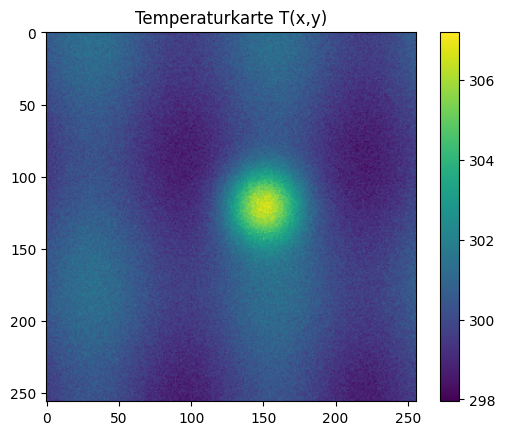

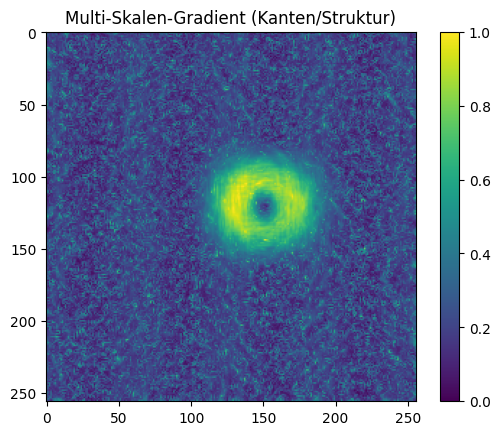

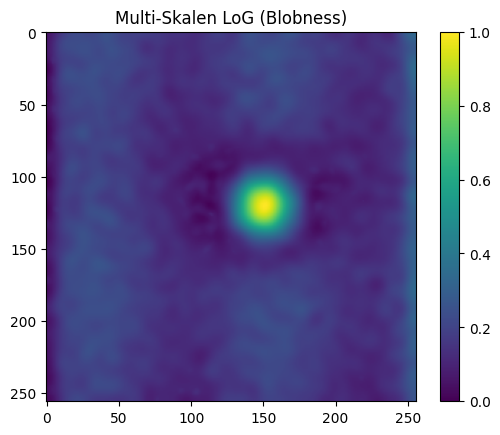

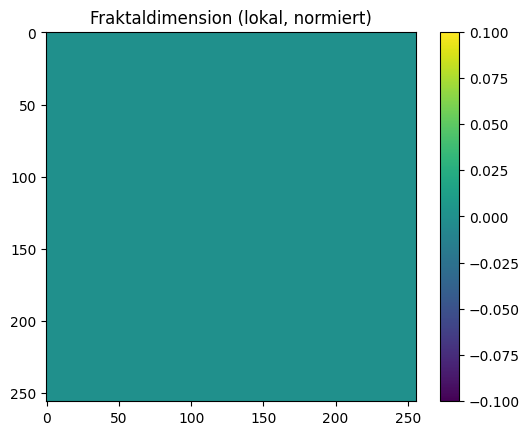

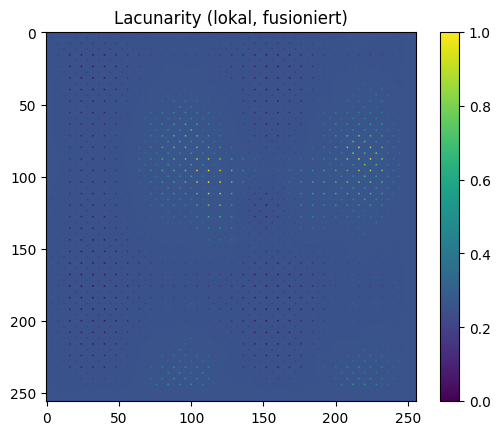

In [12]:
# Visualisierungs-Notebook: Strukturkarten aus einer Temperaturkarte (T)
#
# Was es macht:
# 1) Erzeugt eine synthetische Temperaturkarte (du kannst sie durch deine T(x,y) ersetzen)
# 2) Berechnet professionelle Strukturkarten (Gradient multi-scale, LoG-Blob, GLCM patchweise,
#    Fraktaldimension-Karte, Lacunarity-Karte)
# 3) Visualisiert jede Karte in einer separaten matplotlib-Grafik
#
# Hinweise:
# - Ersetze unten T_demo durch deine reale Temperaturkarte T (2D-ndarray).
# - Wenn scikit-image nicht installiert ist, werden GLCM- und Canny-Schritte übersprungen.
# - Jede Abbildung ist ein eigenes Plot-Fenster; es werden keine Farben manuell gesetzt.

import numpy as np
import matplotlib.pyplot as plt

# optionale Abhängigkeiten
try:
    from scipy import ndimage as ndi
except Exception:
    ndi = None

try:
    from skimage.filters import sobel, laplace
    from skimage.feature import canny, greycomatrix, greycoprops
    SKIMAGE_OK = True
except Exception:
    sobel = laplace = canny = greycomatrix = greycoprops = None
    SKIMAGE_OK = False


def _minmax01(a, eps=1e-12):
    a = np.asarray(a, dtype=float)
    amin, amax = np.nanmin(a), np.nanmax(a)
    if amax - amin < eps:
        return np.zeros_like(a)
    return (a - amin) / (amax - amin)


def _quantize(img, levels=64):
    img01 = _minmax01(img)
    q = np.clip((img01 * (levels - 1)).round().astype(np.uint16), 0, levels - 1)
    return q


def _uniform_filter(img, k):
    if ndi is not None:
        return ndi.uniform_filter(img, size=k, mode="reflect")
    # Fallback ohne SciPy (Integralbild)
    H, W = img.shape
    II = np.pad(img, ((1,0),(1,0)), mode="constant").cumsum(0).cumsum(1)
    r = k // 2
    out = np.empty_like(img, dtype=float)
    for i in range(H):
        i0, i1 = max(0, i-r), min(H, i+r+1)
        for j in range(W):
            j0, j1 = max(0, j-r), min(W, j+r+1)
            area = (i1-i0)*(j1-j0)
            out[i,j] = II[i1,j1] - II[i0,j1] - II[i1,j0] + II[i0,j0]
            out[i,j] /= max(area, 1)
    return out


def gradient_multiscale(T, sobel_sizes=(3, 5, 9)):
    T = np.asarray(T, dtype=float)
    mags = []
    for k in sobel_sizes:
        if ndi is not None:
            gx = ndi.sobel(T, axis=1, mode="reflect")
            gy = ndi.sobel(T, axis=0, mode="reflect")
            if k > 3:
                gx = _uniform_filter(gx, k)
                gy = _uniform_filter(gy, k)
            mag = np.hypot(gx, gy)
        elif SKIMAGE_OK and sobel is not None:
            mag = sobel(T)
            if k > 3:
                mag = _uniform_filter(mag, k)
        else:
            gy, gx = np.gradient(T)
            mag = np.hypot(gx, gy)
            if k > 3:
                mag = _uniform_filter(mag, k)
        mags.append(_minmax01(mag))
    ms = np.max(np.stack(mags, axis=0), axis=0)
    return _minmax01(ms)


def blobs_log_multiscale(T, sigmas=(1.2, 2.5, 4.0, 6.0)):
    T = np.asarray(T, dtype=float)
    if ndi is None and not SKIMAGE_OK:
        # sehr einfacher Fallback
        kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=float)
        pad = np.pad(T, 1, mode='reflect')
        H,W = T.shape
        out = np.zeros_like(T)
        for i in range(H):
            for j in range(W):
                out[i,j] = np.sum(kernel * pad[i:i+3, j:j+3])
        return _minmax01(np.abs(_uniform_filter(out, 5)))
    log_maps = []
    for s in sigmas:
        if ndi is not None:
            g = ndi.gaussian_laplace(T, sigma=s, mode="reflect")
        else:
            # Notlösung ohne sigma-Steuerung
            from skimage.filters import gaussian
            g = laplace(gaussian(T, sigma=s, mode="reflect"))
        log_maps.append(np.abs(g) * (s**2))
    ms = np.max(np.stack(log_maps, axis=0), axis=0)
    return _minmax01(ms)


def canny_edges(T, sigma=1.2, low=0.1, high=0.3):
    if not SKIMAGE_OK or canny is None:
        return None
    return canny(_minmax01(T), sigma=sigma, low_threshold=low, high_threshold=high)


def glcm_feature_maps(T, levels=64, patch=31, step=16,
                      distances=(1, 2), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    if greycomatrix is None or greycoprops is None:
        return None
    Tq = _quantize(T, levels=levels)
    H, W = Tq.shape
    r = patch // 2
    feats = {name: np.full((H, W), np.nan, dtype=float)
             for name in ["contrast", "homogeneity", "energy", "correlation"]}
    for i in range(r, H - r, step):
        for j in range(r, W - r, step):
            sub = Tq[i - r:i + r + 1, j - r:j + r + 1]
            glcm = greycomatrix(sub, distances=distances, angles=angles, levels=levels,
                                symmetric=True, normed=True)
            def gp(name):
                v = greycoprops(glcm, name)
                return float(np.mean(v))
            contrast = gp("contrast")
            homog    = gp("homogeneity")
            asm      = gp("ASM")
            energy   = float(np.sqrt(asm))
            corr     = gp("correlation")
            feats["contrast"][i, j]    = contrast
            feats["homogeneity"][i, j] = homog
            feats["energy"][i, j]      = energy
            feats["correlation"][i, j] = corr
    # Lücken füllen (lokale Mittel)
    for k in feats:
        m = feats[k]
        mask = np.isnan(m)
        if np.any(mask):
            filled = _uniform_filter(np.nan_to_num(m, nan=np.nanmean(m[~mask]) if np.any(~mask) else 0), 9)
            m[mask] = filled[mask]
        feats[k] = _minmax01(m)
    return feats


def fractal_dimension_map(T, win=33, step=16, n_scales=6):
    H, W = T.shape
    r = win // 2
    fd_map = np.full((H, W), np.nan, dtype=float)

    def fd_dbc_local(patch, n_scales=n_scales):
        I = _minmax01(patch)
        h, w = I.shape
        G = max(h, w)
        scales = np.unique(np.round(np.logspace(np.log10(2), np.log10(max(2, min(h,w)//2)), n_scales)).astype(int))
        scales = scales[scales >= 2]
        if len(scales) < 2:
            return np.nan
        Ns, inv_rs = [], []
        for rr in scales:
            nr = int(np.ceil(h / rr)); nc = int(np.ceil(w / rr))
            N_r = 0
            for br in range(nr):
                for bc in range(nc):
                    r0 = br*rr; c0 = bc*rr
                    patch2 = I[r0:min(r0+rr, h), c0:min(c0+rr, w)]
                    if patch2.size == 0:
                        continue
                    gmin, gmax = patch2.min(), patch2.max()
                    kmin = int(np.floor(gmin*(G-1)))
                    kmax = int(np.floor(gmax*(G-1)))
                    N_r += (kmax - kmin + 1)
            Ns.append(N_r); inv_rs.append(1.0/rr)
        x = np.log(np.array(inv_rs)+1e-12)
        y = np.log(np.array(Ns)+1e-12)
        A = np.vstack([x, np.ones_like(x)]).T
        slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(slope)

    for i in range(r, H - r, step):
        for j in range(r, W - r, step):
            sub = T[i - r:i + r + 1, j - r:j + r + 1]
            fd_map[i, j] = fd_dbc_local(sub, n_scales=n_scales)
    mask = np.isnan(fd_map)
    if np.any(mask):
        filled = _uniform_filter(np.nan_to_num(fd_map, nan=np.nanmean(fd_map[~mask]) if np.any(~mask) else 0), 9)
        fd_map[mask] = filled[mask]
    fd_norm = (fd_map - 2.0) / 1.0
    return np.clip(fd_norm, 0.0, 1.0)


def lacunarity_map(T, wins=(9, 17, 33), step=8):
    Tn = _minmax01(T)
    H, W = T.shape
    outs = []
    for win in wins:
        r = win // 2
        Lmap = np.full((H, W), np.nan, dtype=float)
        for i in range(r, H - r, step):
            for j in range(r, W - r, step):
                sub = Tn[i - r:i + r + 1, j - r:j + r + 1]
                m1 = _uniform_filter(sub, win)
                m2 = _uniform_filter(sub**2, win)
                with np.errstate(divide='ignore', invalid='ignore'):
                    L = np.nanmean(m2 / (m1**2 + 1e-12))
                Lmap[i, j] = L
        mask = np.isnan(Lmap)
        if np.any(mask):
            filled = _uniform_filter(np.nan_to_num(Lmap, nan=np.nanmean(Lmap[~mask]) if np.any(~mask) else 0), 9)
            Lmap[mask] = filled[mask]
        outs.append(_minmax01(Lmap))
    Lfusion = np.mean(np.stack(outs, axis=0), axis=0)
    return _minmax01(Lfusion)


def compute_structure_pro(T,
                          sobel_sizes=(3,5,9),
                          log_sigmas=(1.2,2.5,4.0,6.0),
                          glcm_levels=64, glcm_patch=31, glcm_step=16,
                          fd_win=33, fd_step=16, fd_scales=6,
                          lac_wins=(9,17,33), lac_step=8,
                          use_canny=True):
    T = np.asarray(T, dtype=float)
    grad_ms = gradient_multiscale(T, sobel_sizes=sobel_sizes)
    blob_ms = blobs_log_multiscale(T, sigmas=log_sigmas)
    edges   = canny_edges(T) if (use_canny and SKIMAGE_OK) else None
    glcm_maps = glcm_feature_maps(T, levels=glcm_levels,
                                  patch=glcm_patch, step=glcm_step)
    fd_map = fractal_dimension_map(T, win=fd_win, step=fd_step, n_scales=fd_scales)
    lac_map = lacunarity_map(T, wins=lac_wins, step=lac_step)
    return {
        "grad_mag_ms": grad_ms,
        "blob_log_ms": blob_ms,
        "edges_canny": edges,
        "glcm_maps": glcm_maps,
        "fractal_map": fd_map,
        "lacunarity_map": lac_map,
    }


# ---------------------- Demo-Daten ----------------------
H, W = 256, 256
yy, xx = np.mgrid[0:H, 0:W]
base = 300 + 0.8*np.sin(xx/20) + 0.5*np.cos(yy/28)
spot = 6.0 * np.exp(-((xx-150)**2 + (yy-120)**2)/(2*18**2))
noise = np.random.default_rng(0).normal(0, 0.25, size=(H,W))
T_demo = base + spot + noise

# ---------------------- Strukturkarten berechnen ----------------------
maps = compute_structure_pro(T_demo)

# ---------------------- Visualisierung ----------------------
# Jede Karte in einem eigenen Plot; kein explizites Color-Setzen.
plt.figure()
plt.title("Temperaturkarte T(x,y)")
plt.imshow(T_demo)
plt.colorbar()

plt.figure()
plt.title("Multi-Skalen-Gradient (Kanten/Struktur)")
plt.imshow(maps["grad_mag_ms"])
plt.colorbar()

plt.figure()
plt.title("Multi-Skalen LoG (Blobness)")
plt.imshow(maps["blob_log_ms"])
plt.colorbar()

if maps["edges_canny"] is not None:
    plt.figure()
    plt.title("Canny-Kanten (optional)")
    plt.imshow(maps["edges_canny"])
    plt.colorbar()

plt.figure()
plt.title("Fraktaldimension (lokal, normiert)")
plt.imshow(maps["fractal_map"])
plt.colorbar()

plt.figure()
plt.title("Lacunarity (lokal, fusioniert)")
plt.imshow(maps["lacunarity_map"])
plt.colorbar()

if maps["glcm_maps"] is not None:
    for k, m in maps["glcm_maps"].items():
        plt.figure()
        plt.title(f"GLCM – {k}")
        plt.imshow(m)
        plt.colorbar()

# Optional: Speichern aller Bilder als PNGs
import os
outdir = "./structure_viz"
os.makedirs(outdir, exist_ok=True)

# Sammle Figure-Objekte und speichere
for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.savefig(os.path.join(outdir, f"figure_{i}.png"), dpi=150, bbox_inches="tight")

outdir
